In [1]:
import matplotlib.pyplot as plt

import numpy as np
import os
from ctd.comparison.analysis.tt.tt import Analysis_TT 
from ctd.comparison.analysis.tt.tasks.tt_MultiTask import Analysis_TT_MultiTask

from ctd.comparison.analysis.dd.dd import Analysis_DD
# Import pca
import dotenv
from ctd.comparison.comparison import Comparison
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
dotenv.load_dotenv(dotenv.find_dotenv())

True

In [2]:

HOME_DIR = os.environ['HOME_DIR']
print(HOME_DIR)
pathTT_3BFF = HOME_DIR + 'content/trained_models/task-trained/tt_3bff/'
pathTT_MT = HOME_DIR + 'content/trained_models/task-trained/tt_MultiTask/'
pathTT_RT = HOME_DIR + 'content/trained_models/task-trained/tt_RandomTarget/'

an_TT_3BFF = Analysis_TT(run_name = "TT_3BFF", filepath = pathTT_3BFF)
an_TT_MT = Analysis_TT_MultiTask(run_name = "TT_MT", filepath = pathTT_MT)
an_TT_RT = Analysis_TT(run_name = "TT_RT", filepath = pathTT_RT)


path_LDS_Sweep_3BFF = pathTT_3BFF + "20250130_NBFF_LDS_Viz/"
subfolders_LDS_3BFF = [f.path for f in os.scandir(path_LDS_Sweep_3BFF) if f.is_dir()]

path_LDS_Sweep_MT = pathTT_MT + "20250131_MultiTask_LDS_Viz/"
subfolders_LDS_MT = [f.path for f in os.scandir(path_LDS_Sweep_MT) if f.is_dir()]

path_LDS_Sweep_RT = pathTT_RT + "20250130_RandomTarget_LDS_Viz/"
subfolders_LDS_RT = [f.path for f in os.scandir(path_LDS_Sweep_RT) if f.is_dir()]

/home/csverst/Github/CtDBenchmark/


In [3]:
comparison_3BFF = Comparison(comparison_tag="3BFF")
comparison_3BFF.load_analysis(an_TT_3BFF, reference_analysis=True, group = "TT")

for subfolder in subfolders_LDS_3BFF:
    subfolder = subfolder + "/"
    analysis_LDS = Analysis_DD.create(run_name = "LDS", filepath = subfolder, model_type = "SAE")
    comparison_3BFF.load_analysis(analysis_LDS, group = "LDS")

comparison_3BFF.regroup()
# comparison_3BFF.plot_trials(num_trials=2)

In [4]:
comparison_NBFF_single = Comparison(comparison_tag="NBFF_single")
comparison_NBFF_single.load_analysis(an_TT_3BFF, reference_analysis=True, group = "TT")
comparison_NBFF_single.load_analysis(analysis_LDS, group = "LDS")

In [11]:

nbff_spikes = analysis_LDS.get_spiking(phase="val")
latents = an_TT_3BFF.get_latents(phase="val")

nbff_spikes = nbff_spikes.detach().cpu().numpy()
latents= latents.detach().cpu().numpy()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting
from matplotlib import gridspec
from sklearn.decomposition import PCA

# -------------------------------------------------------------------
# Data Setup
# -------------------------------------------------------------------
# Replace these with your actual data:
# nbff_spikes = analysis_LDS.get_spiking(phase="val")   # shape: (B, T, N)
# latents     = an_TT_3BFF.get_latents(phase="val")      # shape: (B, T, D)
#
# For demonstration purposes, we assume nbff_spikes and latents are already loaded.
# If needed, you can simulate data as follows:
#
# B, T, N, D = 10, 100, 50, 10
# nbff_spikes = np.random.poisson(0.5, size=(B, T, N))
# latents     = np.random.randn(B, T, D)

B, T, N = nbff_spikes.shape
_, _, D = latents.shape

# Set the number of trials to include in the combined video (must be ≤ B).
Y = 6  # Change as needed
frame_skip = 2  # Adjust this value as desired (maximum allowed is 4)

# -------------------------------------------------------------------
# Compute the top-3 Principal Components (PCs)
# -------------------------------------------------------------------
latents_all = latents.reshape(-1, D)
pca = PCA(n_components=3)
pca.fit(latents_all)
all_pc = pca.transform(latents_all)  # shape: (B*T, 3)

# Compute the min and max for each PC across all latent data.
x_min, x_max = np.min(all_pc[:, 0]), np.max(all_pc[:, 0])
y_min, y_max = np.min(all_pc[:, 1]), np.max(all_pc[:, 1])
z_min, z_max = np.min(all_pc[:, 2]), np.max(all_pc[:, 2])

# Precompute the PC coordinates for each trial (for Y trials).
pc_coords_all = np.empty((Y, T, 3))
for trial in range(Y):
    trial_latents = latents[trial, :, :]
    pc_coords_all[trial] = pca.transform(trial_latents)

# -------------------------------------------------------------------
# Setup Colors for Each Trial
# -------------------------------------------------------------------
# Use a colormap (here, tab10) to assign distinct colors to each trial.
colors = plt.cm.tab10(np.linspace(0, 1, Y))

# -------------------------------------------------------------------
# Create the Figure and Subplots with GridSpec
# -------------------------------------------------------------------
fig = plt.figure(figsize=(12, 6))
# Use GridSpec to set the imshow panel to 75% of the width of the 3D panel.
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.75])

# Left subplot: 3D latent trajectory.
ax_pc = fig.add_subplot(gs[0], projection='3d')
ax_pc.set_title("Trial 1: Latent Trajectory (Top 3 PCs)")
ax_pc.set_xlabel("PC1")
ax_pc.set_ylabel("PC2")
ax_pc.set_zlabel("PC3")
ax_pc.set_xlim(x_min, x_max)
ax_pc.set_ylim(y_min, y_max)
ax_pc.set_zlim(z_min, z_max)
ax_pc.set_xticklabels([])
ax_pc.set_yticklabels([])
ax_pc.set_zticklabels([])
# Initialize the active trail line and current point using the first trial’s color.
trail_line, = ax_pc.plot([], [], [], color=colors[0], lw=2)
current_point = ax_pc.scatter([], [], [], color=colors[0], s=50)

# Right subplot: Spiking activity.
ax_spike = fig.add_subplot(gs[1])
ax_spike.set_title("Trial 1: Spiking Activity")
# Transpose so that time is on the x-axis and neurons on the y-axis.
im = ax_spike.imshow(nbff_spikes[0].T, aspect='auto',
                     interpolation='nearest', cmap='viridis')
ax_spike.set_xlabel("Time")
ax_spike.set_ylabel("Neuron")
plt.colorbar(im, ax=ax_spike, orientation='vertical')
# Add a vertical red line to indicate the current time point.
vline = ax_spike.axvline(x=0, color='red', lw=2)

# -------------------------------------------------------------------
# Frame Skipping Setup (to speed up the animation)
# -------------------------------------------------------------------
# You are allowed to skip frames if needed, but not more than 4 frames.
# Set frame_skip to 1 (no skip), 2, 3, or 4.

# The total number of "effective" frames is Y*T.
total_effective_frames = Y * T
# The number of frames in the animation will be reduced by the frame_skip factor.
n_frames = int(np.ceil(total_effective_frames / frame_skip))

# -------------------------------------------------------------------
# Define the Update Function for the Animation
# -------------------------------------------------------------------
def update(frame):
    global trail_line, current_point
    # Compute the effective frame number by skipping frames.
    eff_frame = min(frame * frame_skip, total_effective_frames - 1)
    trial_idx = eff_frame // T      # Current trial index (0-indexed)
    time_idx  = eff_frame % T       # Current time point within the trial

    # When starting a new trial:
    if time_idx == 0:
        print(f"Trial: {trial_idx}")
        # For trials after the first, permanently plot the previous trial's trajectory
        # with its designated color in transparent mode.
        if trial_idx > 0:
            prev_pc = pc_coords_all[trial_idx - 1]
            ax_pc.plot(prev_pc[:, 0], prev_pc[:, 1], prev_pc[:, 2],
                       color=colors[trial_idx - 1], alpha=0.3, lw=2)
        # Update the active trail line's color to that of the current trial.
        trail_line.set_color(colors[trial_idx])
        
        # Update spiking activity and subplot titles for the new trial.
        im.set_data(nbff_spikes[trial_idx].T)
        ax_spike.set_title(f"Trial {trial_idx+1}: Spiking Activity")
        ax_pc.set_title(f"Trial {trial_idx+1}: Latent Trajectory (Top 3 PCs)")
        # Clear the active trail data.
        trail_line.set_data([], [])
        trail_line.set_3d_properties([])
        
        # Remove the old current point and create a new one with the current trial's color.
        current_point.remove()
        current_point = ax_pc.scatter([], [], [], color=colors[trial_idx], s=50)

    # Get the precomputed PC coordinates for the current trial.
    current_pc = pc_coords_all[trial_idx]
    # Update the active trail line with all points up to the current time.
    xs = current_pc[:time_idx+1, 0]
    ys = current_pc[:time_idx+1, 1]
    zs = current_pc[:time_idx+1, 2]
    trail_line.set_data(xs, ys)
    trail_line.set_3d_properties(zs)
    
    # Update the current point (marker) to the current coordinate.
    cp = current_pc[time_idx]
    current_point._offsets3d = ([cp[0]], [cp[1]], [cp[2]])
    
    # Update the vertical line in the spiking activity plot.
    vline.set_xdata(time_idx)
    
    # Slowly rotate the 3D axes.
    # Here, we make a full 360° rotation over the entire animation.
    current_azim = 360 * frame / n_frames
    # Optionally, you can also adjust the elevation if desired (here fixed at 30°).
    ax_pc.view_init(elev=30, azim=current_azim)
    
    return trail_line, current_point, vline, im

# -------------------------------------------------------------------
# Create and Save the Animation
# -------------------------------------------------------------------
# Set the interval to ~16.67 ms for 60 frames per second.
interval_ms = 1000 / 60

ani = FuncAnimation(fig, update, frames=n_frames, interval=interval_ms, blit=False)

# Save the combined animation as an MP4 video with 60 fps.
writer = FFMpegWriter(fps=60)
ani.save("combined_trials_animation.mp4", writer=writer)

plt.close(fig)
print("Combined video saved as 'combined_trials_animation.mp4'.")


/tmp/ipykernel_3836582/3179437506.py:147: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(time_idx)


Combined video saved as 'combined_trials_animation.mp4'.


In [3]:
comparison_MT = Comparison(comparison_tag="MultiTask")
comparison_MT.load_analysis(an_TT_MT, reference_analysis=True, group = "TT")

for subfolder in subfolders_LDS_MT:
    subfolder = subfolder + "/"
    analysis_LDS = Analysis_DD.create(run_name = "LDS", filepath = subfolder, model_type = "SAE")
    comparison_MT.load_analysis(analysis_LDS, group = "LDS")
    
comparison_MT.regroup()

In [11]:
mt_spikes = analysis_LDS.get_spiking(phase="all")
mt_latents = an_TT_MT.get_latents(phase = "all")
mt_task_flag, phase_dict = an_TT_MT.get_task_flag('MemoryPro', phase = "all")


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting
from matplotlib import gridspec
from sklearn.decomposition import PCA

# ============================================================================
# 1. Data Setup
# ============================================================================

# These variables come from your analysis:
#   mt_spikes = analysis_LDS.get_spiking(phase="all")      # shape: (B, T_max, N)
#   mt_latents = an_TT_MT.get_latents(phase="all")           # shape: (B, T_max, D)
#   mt_task_flag, phase_dict = an_TT_MT.get_task_flag('MemoryPro', phase="all")
#
# Then, you select only the MemoryPro trials:
mt_memPro_spikes = mt_spikes[mt_task_flag, :, :].detach().cpu().numpy()
mt_memPro_latents = mt_latents[mt_task_flag, :, :].detach().cpu().numpy()

# phase_dict is a list of dictionaries (one per trial).  
# Each dictionary has keys equal to the phases (e.g. 'cue', 'delay', 'response', …)
# and values like [start, end] (for example, phase_dict[0]['response'] might be [45, 67],
# meaning that the 'response' phase runs from time index 45 to 67, inclusive).
#
# We assume that the trial’s effective length is given by the second element of the 
# 'response' phase. (If your response times are inclusive, you might want to add 1.)
trial_lengths = []
for d in phase_dict:
    # If response is inclusive, add one:
    trial_lengths.append(d['response'][1] + 1)
    
# Compute cumulative lengths to map global frame indices to (trial, time)
cumulative_lengths = np.cumsum(trial_lengths)
total_effective_frames = cumulative_lengths[-1]

# ============================================================================
# 2. Compute PCA on All Latent Data (truncated to each trial’s effective length)
# ============================================================================

all_latents_list = []
for i, length in enumerate(trial_lengths):
    # Use only the first "length" frames of trial i.
    all_latents_list.append(mt_memPro_latents[i, :length, :])
all_latents_concat = np.concatenate(all_latents_list, axis=0)

pca = PCA(n_components=3)
pca.fit(all_latents_concat)

# Transform each trial’s latent data and store in a list.
trial_pc_list = []
for i, length in enumerate(trial_lengths):
    trial_latents = mt_memPro_latents[i, :length, :]
    trial_pc = pca.transform(trial_latents)  # shape: (length, 3)
    trial_pc_list.append(trial_pc)

# ============================================================================
# 3. Set Up Phase Colors
# ============================================================================

# First, collect all unique phase names from all trials.
phase_names = set()
for d in phase_dict:
    for phase in d.keys():
        phase_names.add(phase)
phase_names = sorted(list(phase_names))

# Assign a distinct color to each phase using a colormap.
colors_phase = plt.cm.tab10(np.linspace(0, 1, len(phase_names)))
phase_color_map = {phase: colors_phase[i] for i, phase in enumerate(phase_names)}

# ============================================================================
# 4. Animation Setup
# ============================================================================

# Frame skipping: allowed to skip up to 4 frames.
frame_skip = 2  # Set 1 (no skip), 2, 3, or 4 as desired.
n_frames = int(np.ceil(total_effective_frames / frame_skip))

# Create a figure with two subplots: left is the 3D latent trajectory,
# right is the spiking activity (with width set to 75% of left).
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.75])

# --- 3D latent trajectory subplot ---
ax_pc = fig.add_subplot(gs[0], projection='3d')
ax_pc.set_title("Trial 1: Latent Trajectory")
ax_pc.set_xlabel("PC1")
ax_pc.set_ylabel("PC2")
ax_pc.set_zlabel("PC3")
# Set axis limits based on PCA-transformed data over all trials.
all_pc = pca.transform(all_latents_concat)
ax_pc.set_xlim(np.min(all_pc[:, 0]), np.max(all_pc[:, 0]))
ax_pc.set_ylim(np.min(all_pc[:, 1]), np.max(all_pc[:, 1]))
ax_pc.set_zlim(np.min(all_pc[:, 2]), np.max(all_pc[:, 2]))

# Initialize an active trail line (empty) and a scatter point.
# (Their color will be updated based on the current phase.)
trail_line, = ax_pc.plot([], [], [], lw=2)
current_point = ax_pc.scatter([], [], [], s=50)

# --- Spiking activity subplot ---
ax_spike = fig.add_subplot(gs[1])
ax_spike.set_title("Trial 1: Spiking Activity")
# Show the spiking data for trial 0 (truncated to its effective length),
# transposed so that time is on the x-axis and neurons on the y-axis.
im = ax_spike.imshow(mt_memPro_spikes[0, :trial_lengths[0], :].T, aspect='auto',
                     interpolation='nearest', cmap='viridis')
ax_spike.set_xlabel("Time")
ax_spike.set_ylabel("Neuron")
plt.colorbar(im, ax=ax_spike, orientation='vertical')
vline = ax_spike.axvline(x=0, color='red', lw=2)

# --- Global variables for phase segmentation ---
global_current_trial = -1  # to detect when a new trial starts
last_phase = None          # last phase seen (for the current trial)
phase_segment_start = 0    # time index within the current trial when the current phase began

# ============================================================================
# 5. Update Function for the Animation
# ============================================================================

def update(frame):
    global global_current_trial, last_phase, phase_segment_start
    global trail_line, current_point

    # Compute the effective global frame index (with skipping)
    eff_frame = min(frame * frame_skip, total_effective_frames - 1)

    # Determine which trial (trial_idx) and time index within that trial (time_idx)
    trial_idx = np.searchsorted(cumulative_lengths, eff_frame, side='right')
    if trial_idx > 0:
        time_idx = eff_frame - cumulative_lengths[trial_idx - 1]
    else:
        time_idx = eff_frame

    # If we've moved to a new trial, update global variables and reset the active trail.
    if trial_idx != global_current_trial:
        print(f"Trial: {trial_idx}")
        # If we were in a previous trial, you might choose to "freeze" its last phase segment.
        # (In this example, we simply start fresh for the new trial.)
        global_current_trial = trial_idx
        last_phase = None
        phase_segment_start = 0

        # Update spiking plot with current trial's data.
        im.set_data(mt_memPro_spikes[trial_idx, :trial_lengths[trial_idx], :].T)
        ax_spike.set_title(f"Trial {trial_idx+1}: Spiking Activity")
        ax_pc.set_title(f"Trial {trial_idx+1}: Latent Trajectory")
        
        # Clear the active trail.
        trail_line.set_data([], [])
        trail_line.set_3d_properties([])
        # Remove and recreate the current point.
        current_point.remove()
        current_point = ax_pc.scatter([], [], [], s=50)

    # --- Determine the current phase for this trial at time index 'time_idx' ---
    # We assume that for trial trial_idx, phase_dict[trial_idx] is a dict mapping phase names to [start, end].
    trial_phase_info = phase_dict[trial_idx]
    current_phase = None
    for phase, (p_start, p_end) in trial_phase_info.items():
        # We assume inclusive boundaries (adjust <= vs < as needed)
        if p_start <= time_idx <= p_end:
            current_phase = phase
            break
    if current_phase is None:
        current_phase = "unknown"
    
    # --- Check for phase transition ---
    if last_phase is None:
        # First frame of this trial.
        last_phase = current_phase
        phase_segment_start = time_idx
        # Set active color to that of the current phase.
        active_color = phase_color_map.get(current_phase, 'black')
        trail_line.set_color(active_color)
    elif current_phase != last_phase:
        # Phase has changed! Permanently plot the finished segment in its phase color with transparency.
        trial_pc = trial_pc_list[trial_idx]
        segment = trial_pc[phase_segment_start:time_idx, :]
        if segment.shape[0] > 0:
            ax_pc.plot(segment[:, 0], segment[:, 1], segment[:, 2],
                       color=phase_color_map.get(last_phase, 'black'), alpha=0.3, lw=2)
        # Update for the new phase:
        last_phase = current_phase
        phase_segment_start = time_idx
        trail_line.set_color(phase_color_map.get(current_phase, 'black'))

    # --- Update the active trail line for the current phase segment ---
    trial_pc = trial_pc_list[trial_idx]
    active_segment = trial_pc[phase_segment_start:time_idx+1, :]
    if active_segment.shape[0] > 0:
        xs = active_segment[:, 0]
        ys = active_segment[:, 1]
        zs = active_segment[:, 2]
        trail_line.set_data(xs, ys)
        trail_line.set_3d_properties(zs)
        # Update current point to the last point in the segment.
        cp = active_segment[-1, :]
        current_point._offsets3d = ([cp[0]], [cp[1]], [cp[2]])

    # --- Update the vertical red line on the spiking plot ---
    vline.set_xdata(time_idx)
    
    # --- Optionally, update the subplot title to indicate the current phase ---
    ax_pc.set_title(f"Trial {trial_idx+1}: Latent Trajectory (Phase: {current_phase})")

    # --- Slowly rotate the 3D view ---
    current_azim = 360 * frame / n_frames
    ax_pc.view_init(elev=30, azim=current_azim)
    
    return trail_line, current_point, vline, im

# ============================================================================
# 6. Create and Save the Animation
# ============================================================================

interval_ms = 1000 / 60  # ~16.67 ms per frame (60 fps)

ani = FuncAnimation(fig, update, frames=n_frames, interval=interval_ms, blit=False)
writer = FFMpegWriter(fps=60)
ani.save("combined_trials_phase_colored_animation.mp4", writer=writer)

plt.close(fig)
print("Combined video saved as 'combined_trials_phase_colored_animation.mp4'.")


/tmp/ipykernel_4151764/1037372138.py:203: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vline.set_xdata(time_idx)


In [8]:
pred_fr_LDS = analysis_LDS.get_rates(phase ='val').detach().cpu().numpy()
true_fr = analysis_LDS.get_true_rates(phase = 'val').detach().cpu().numpy()
trial_lens= analysis_LDS.get_trial_lens(phase= "val").detach().cpu().numpy()
pred_fr_LFADS = analysis_LFADS.get_rates(phase ='val').detach().cpu().numpy()
# pred_fr_GRU = analysis_GRU.get_rates(phase='val').detach().cpu().numpy()



In [9]:
print(pred_fr_LDS.shape)
print(true_fr.shape)
print(trial_lens)
pred_fr_list_LDS = []
true_fr_list = []
pred_fr_list_LFADS = []
pred_fr_list_GRU = []

for i in range(len(trial_lens)):
    pred_fr_list_LDS.append(pred_fr_LDS[i,:int(trial_lens[i]),:])
    true_fr_list.append(true_fr[i,:int(trial_lens[i]),:])


(1500, 320, 60)
(1500, 320, 60)
[167. 224. 194. ... 129. 126. 114.]


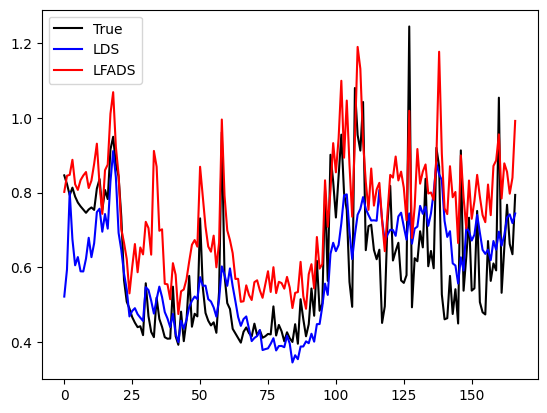

In [10]:

trial_num=0
neuron_num =4
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(true_fr_list[trial_num][:,neuron_num], color = 'k', label = 'True')
ax.plot(pred_fr_list_LDS[trial_num][:,neuron_num], color = 'b', label = 'LDS')
ax.legend()


In [11]:
comparison_MT_single = Comparison(comparison_tag="MT_single")
comparison_MT_single.load_analysis(an_TT_MT, reference_analysis=True, group = "TT")
comparison_MT_single.load_analysis(analysis_LFADS, group = "LFADS")
# comparison_MT_single.load_analysis(analysis_GRU, group = "GRU")
comparison_MT_single.load_analysis(analysis_LDS, group = "LDS")


In [12]:
# comparison_temp.compare_rate_state_r2()
trial_lens= analysis_LFADS.get_trial_lens(phase= "val")
lats_true = an_TT_MT.get_latents(phase= "val")
extra = an_TT_MT.get_extra_inputs(phase= "val")
noiseless_inputs = an_TT_MT.get_model_inputs_noiseless(phase= "val")
lats_lfads = analysis_LFADS.get_latents(phase= "val")
# lats_gru = analysis_GRU.get_latents(phase ="val")
lats_lds = analysis_LDS.get_latents(phase = "val")

lats_true_s =[]
lats_lfads_s = []
lats_gru_s = []
lats_lds_s = []

for i in range(len(trial_lens)):
    lats_true_s.append(lats_true[i][:int(trial_lens[i])].detach().numpy())
    lats_lfads_s.append(lats_lfads[i][:int(trial_lens[i])].detach().numpy())
    # lats_gru_s.append(lats_gru[i][:int(trial_lens[i])].detach().numpy())
    lats_lds_s.append(lats_lds[i][:int(trial_lens[i])].detach().numpy())

lats_true_s = np.concatenate(lats_true_s, axis = 0)
lats_lfads_s = np.concatenate(lats_lfads_s, axis = 0)
# lats_gru_s = np.concatenate(lats_gru_s, axis = 0)
lats_lds_s = np.concatenate(lats_lds_s, axis = 0)

    

In [13]:
print(lats_true.shape)

torch.Size([1500, 320, 128])


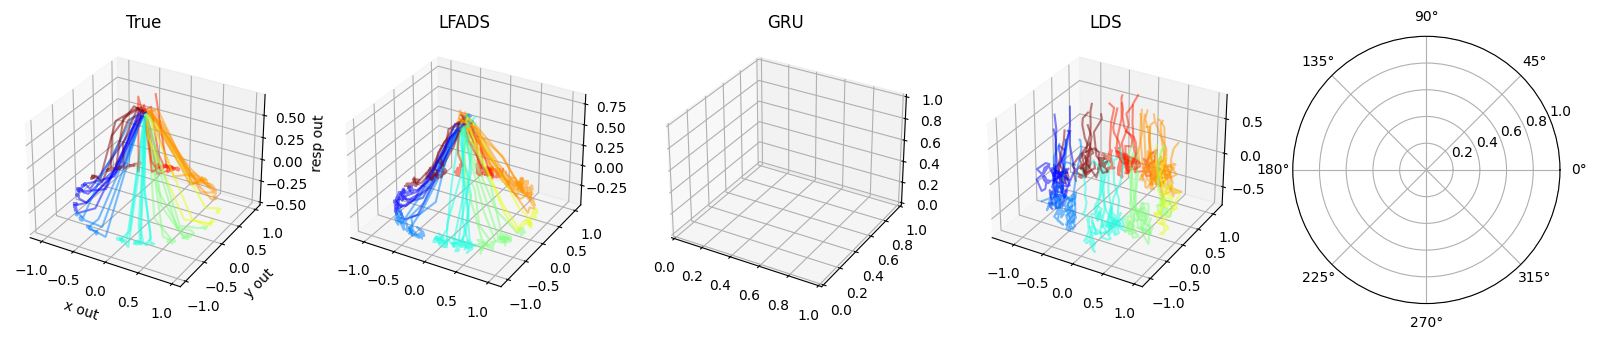

In [15]:
input_list = an_TT_MT.env.input_labels
memPro_ind = 6
use_pca= False
memPro_trials = []
for i in range(noiseless_inputs[1].shape[0]):
    if noiseless_inputs[1][i,0,memPro_ind] == 1:
        memPro_trials.append(i)

resp_start = extra[memPro_trials, 0].detach().numpy()
resp_end = extra[memPro_trials, 1].detach().numpy()
targets = an_TT_MT.get_model_inputs(phase = "val")[2]
memProTargs = np.zeros((len(memPro_trials), 2))
for i in range(len(memPro_trials)):
    memProTargs[i,:] = targets[memPro_trials[i], int(resp_end[i])-1, 1:]

memProAngs = np.arctan2(memProTargs[:,1], memProTargs[:,0])
memProBins = np.digitize(memProAngs, np.linspace(-np.pi, np.pi, 9))


lats_true_memPro = lats_true[memPro_trials]
lats_lfads_memPro = lats_lfads[memPro_trials]
# lats_gru_memPro = lats_gru[memPro_trials]
lats_lds_memPro = lats_lds[memPro_trials]

lats_true_memPro_s =[]
lats_lfads_memPro_s = []
lats_gru_memPro_s = []
lats_lds_memPro_s = []
for i in range(lats_true_memPro.shape[0]):
    lats_true_memPro_s.append(lats_true_memPro[i][int(resp_start[i]):int(resp_end[i])].detach().numpy())
    lats_lfads_memPro_s.append(lats_lfads_memPro[i][int(resp_start[i]):int(resp_end[i])].detach().numpy())
    # lats_gru_memPro_s.append(lats_gru_memPro[i][int(resp_start[i]):int(resp_end[i])].detach().numpy())
    lats_lds_memPro_s.append(lats_lds_memPro[i][int(resp_start[i]):int(resp_end[i])].detach().numpy())

lats_true_memPro_s1 = np.concatenate(lats_true_memPro_s, axis = 0)
lats_lfads_memPro_s1 = np.concatenate(lats_lfads_memPro_s, axis = 0)
# lats_gru_memPro_s1 = np.concatenate(lats_gru_memPro_s, axis = 0)
lats_lds_memPro_s1 = np.concatenate(lats_lds_memPro_s, axis = 0)

readout = an_TT_MT.model.readout
wt = readout.weight.detach().numpy()
x_wt = wt[1,:]
y_wt = wt[2,:]
resp_wt = wt[0,:]

pca_memPro = PCA(n_components=3)
pca_memPro.fit(lats_true_memPro_s1)
lats_true_memPro_s1_pca = pca_memPro.transform(lats_true_memPro_s1)

x_proj = np.dot(lats_true_memPro_s1, x_wt)
y_proj = np.dot(lats_true_memPro_s1, y_wt)
resp_proj = np.dot(lats_true_memPro_s1, resp_wt)

lats_true_memPro_s1_wts = np.stack(( x_proj, y_proj, resp_proj), axis = 1)

lr_lfads = LinearRegression()
lr_gru = LinearRegression()
lr_lds = LinearRegression()

if use_pca:
    lr_lfads.fit(lats_lfads_memPro_s1, lats_true_memPro_s1_pca)
    # lr_gru.fit(lats_gru_memPro_s1, lats_true_memPro_s1_pca)
    lr_lds.fit(lats_lds_memPro_s1, lats_true_memPro_s1_pca)
else:

    lr_lfads.fit(lats_lfads_memPro_s1, lats_true_memPro_s1_wts)
    # lr_gru.fit(lats_gru_memPro_s1, lats_true_memPro_s1_wts)
    lr_lds.fit(lats_lds_memPro_s1, lats_true_memPro_s1_wts)
    
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(151, projection='3d')
ax2 = fig.add_subplot(152, projection='3d')
ax3 = fig.add_subplot(153, projection='3d')
ax4 = fig.add_subplot(154, projection='3d')
ax5 = fig.add_subplot(155, projection='polar')
for i in range(50):
    if use_pca:
        true_pca = pca_memPro.transform(lats_true_memPro_s[i])
    else:
        xP = np.dot(lats_true_memPro_s[i], x_wt)
        yP = np.dot(lats_true_memPro_s[i], y_wt)
        respP = np.dot(lats_true_memPro_s[i], resp_wt)
        true_pca = np.stack((xP,yP, respP), axis = 1)
    pred_lfads = lr_lfads.predict(lats_lfads_memPro_s[i])
    # pred_gru = lr_gru.predict(lats_gru_memPro_s[i])
    pred_lds = lr_lds.predict(lats_lds_memPro_s[i])
    colorBin = memProBins[i]
    color = plt.cm.jet(colorBin/8)
    ax1.plot(true_pca[:,0], true_pca[:,1], true_pca[:,2], color = color, alpha = 0.5)
    ax2.plot(pred_lfads[:,0], pred_lfads[:,1], pred_lfads[:,2], color = color, alpha = 0.5)
    # ax3.plot(pred_gru[:,0], pred_gru[:,1], pred_gru[:,2], color = color, alpha = 0.5)
    ax4.plot(pred_lds[:,0], pred_lds[:,1], pred_lds[:,2], color = color, alpha = 0.5)


ax1.set_title("True")
ax2.set_title("LFADS")
ax3.set_title("GRU")
ax4.set_title("LDS")

if use_pca:
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")
else:
    ax1.set_xlabel("x out")
    ax1.set_ylabel("y out")
    ax1.set_zlabel("resp out")




# lats_

In [16]:
targets_memPro = targets[memPro_trials]
resp_start1 = resp_start[0]
resp_end1 = resp_end[0]


In [18]:
num_trials =10
pca = PCA(n_components=3)
pca.fit(lats_true_s)
lats_true_s_pca = pca.transform(lats_true_s)
lr_lfads = LinearRegression()
lr_lfads.fit(lats_lfads_s, lats_true_s_pca)
lats_lfads_to_true = lr_lfads.predict(lats_lfads_s)
lr_gru = LinearRegression()
# lr_gru.fit(lats_gru_s, lats_true_s_pca)
# lats_gru_to_true = lr_gru.predict(lats_gru_s)
lr_lds = LinearRegression()
lr_lds.fit(lats_lds_s, lats_true_s_pca)
lats_lds_to_true = lr_lds.predict(lats_lds_s)

true_plot= []
lfads_plot = []
gru_plot = []
lds_plot = []
for i in range(num_trials):
    true_trial_pca = pca.transform(lats_true[i][:int(trial_lens[i])].detach().numpy())
    true_plot.append(true_trial_pca)
    lfads_trial_pca = lr_lfads.predict(lats_lfads[i][:int(trial_lens[i])].detach().numpy())
    lfads_plot.append(lfads_trial_pca)
    # gru_trial_pca = lr_gru.predict(lats_gru[i][:int(trial_lens[i])].detach().numpy())
    # gru_plot.append(gru_trial_pca)
    lds_trial_pca = lr_lds.predict(lats_lds[i][:int(trial_lens[i])].detach().numpy())
    lds_plot.append(lds_trial_pca)
    

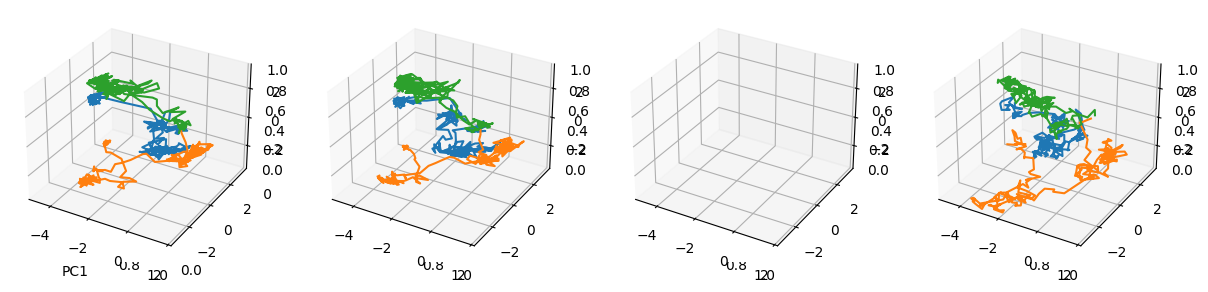

In [20]:
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(1, 4, sharex=True, sharey=True,  subplot_kw={'projection': '3d'})
ax1 = fig.add_subplot(1,4,1, projection='3d')
ax2 = fig.add_subplot(1,4,2, projection='3d')
ax3 = fig.add_subplot(1,4,3, projection='3d')
ax4 = fig.add_subplot(1,4,4, projection='3d')

for i in range(3):
    ax1.plot(true_plot[i][:,0], true_plot[i][:,1], true_plot[i][:,2])
    ax2.plot(lfads_plot[i][:,0], lfads_plot[i][:,1], lfads_plot[i][:,2])
    # ax3.plot(gru_plot[i][:,0], gru_plot[i][:,1], gru_plot[i][:,2])
    ax4.plot(lds_plot[i][:,0], lds_plot[i][:,1], lds_plot[i][:,2])

ax1.set_xlabel("PC1")
ax1.set_xlim([-5, 2])
ax2.set_xlim([-5, 2])
ax3.set_xlim([-5, 2])
ax4.set_xlim([-5, 2])
ax1.set_ylim([-3.5, 3.5])
ax2.set_ylim([-3.5, 3.5])
ax3.set_ylim([-3.5, 3.5])
ax4.set_ylim([-3.5, 3.5])
ax1.set_zlim([-3.5, 3.5])
ax2.set_zlim([-3.5, 3.5])
ax3.set_zlim([-3.5, 3.5])
ax4.set_zlim([-3.5, 3.5])


plt.savefig("MT.pdf")


In [21]:
comparison_RT = Comparison(comparison_tag="RandomTarget")
comparison_RT.load_analysis(an_TT_RT, reference_analysis=True, group = "TT")

for subfolder in subfolders_GRU_RT:
    subfolder = subfolder + "/"
    analysis_GRU = Analysis_DD.create(run_name = "GRU", filepath = subfolder, model_type = "SAE")
    comparison_RT.load_analysis(analysis_GRU, group = "GRU")

for subfolder in subfolders_LFADS_RT:
    subfolder = subfolder + "/"
    analysis_LFADS = Analysis_DD.create(run_name = "LFADS", filepath = subfolder, model_type = "LFADS")
    comparison_RT.load_analysis(analysis_LFADS, group = "LFADS")

for subfolder in subfolders_LDS_RT:
    subfolder = subfolder + "/"
    analysis_LDS = Analysis_DD.create(run_name = "LDS", filepath = subfolder, model_type = "SAE")
    comparison_RT.load_analysis(analysis_LDS, group = "LDS")


comparison_RT.regroup()

In [22]:
comparison_RT_single = Comparison(comparison_tag="RT_single")
comparison_RT_single.load_analysis(an_TT_RT, reference_analysis=True, group = "TT")
comparison_RT_single.load_analysis(analysis_LFADS, group = "LFADS")
comparison_RT_single.load_analysis(analysis_GRU, group = "GRU")
comparison_RT_single.load_analysis(analysis_LDS, group = "LDS")


In [23]:

def plot_radial_histogram(data, bins=30):
    """
    Plots a radial histogram.

    Parameters:
    data (array-like): The data to plot.
    bins (int): The number of bins in the histogram.

    Returns:
    None
    """
    # Compute the histogram
    hist, bin_edges = np.histogram(data, bins=bins)

    # Compute the width of each bin
    widths = np.diff(bin_edges)

    # Compute the angles for each bin
    theta = bin_edges[:-1] * 2 * np.pi / bin_edges[-1]

    # Create the plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    # Plot the histogram
    bars = ax.bar(theta, hist, width=widths, bottom=0.0, align='edge')

    # Add some color to the bars
    for bar in bars:
        bar.set_facecolor(plt.cm.viridis(bar.get_height() / max(hist)))
        bar.set_alpha(0.7)

    plt.show()

[4 5 1 1 6 5 5 6 2 4 1 1 5 2 1 2 2 1 8 1 1 6 5 5 2 1 6 4 1 1 8 5 5 5 5 6 1
 1 1 8 6 5 2 1 3 8 7 6 5 5 1 4 4 6 3 2 6 4 1 1 6 1 5 6 7 4 2 1 1 6 2 1 3 5
 5 2 1 2 3 6 3 5 7 2 8 7 5 2 1 5 2 1 8 6 5 1 3 5 6 1 8 8 3 1 1 2 6 5 1 6 1
 1 8 8 5 1 5 6 2 6 1 3 1 8 5 6 2 2 1 2 5 1 1 5 2 5 5 5 8 2 4 5 6 4 5 1 7 6
 8 1 5 5 4 2 1 5 6 5 5 8 5 5 6 2 1 8 7 1 6 5 4 1 1 1 1 2 1 2 6 4 5 5 3 4 6
 1 1 3 5 4 2 8 5 8 1 8 5 8 5 5]


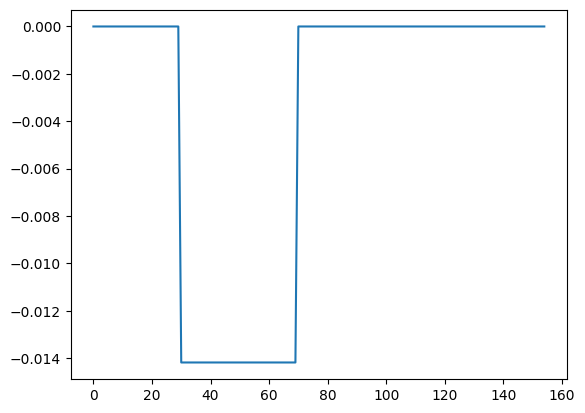

In [24]:
#comparison_RT_single.plot_trials_3d_reference(num_trials=3, savePDF=True)
lats_true = an_TT_RT.get_latents(phase= "val")
lats_lfads = analysis_LFADS.get_latents(phase= "val")
lats_gru = analysis_GRU.get_latents(phase ="val")
lats_lds = analysis_LDS.get_latents(phase = "val")

endpoint_pos = an_TT_RT.get_model_outputs(phase= "val")['controlled'].detach().numpy()
inputs_true = an_TT_RT.get_true_inputs(phase= "val")
env_inputs = an_TT_RT.get_model_inputs_noiseless(phase= "val")
start_pos = endpoint_pos[:,0,:]
targ_pos = inputs_true[:,40,:2]
reach_ang = np.arctan2(targ_pos[:,1]-start_pos[:,1], targ_pos[:,0]-start_pos[:,0])

n_bins = 8
# plt.hist(reach_ang, bins=n_bins)
plt.plot(inputs_true[0,:,0])
# Bin trials by reach angle
bins = np.linspace(-np.pi, np.pi, n_bins+1)
reach_ang_bins = np.digitize(reach_ang, bins)
print(reach_ang_bins)

reach_start = 60
reach_end = 100

lats_true = lats_true.detach().numpy()
lats_true = lats_true[:,reach_start:reach_end,:]
lats_lfads = lats_lfads.detach().numpy()
lats_lfads = lats_lfads[:,reach_start:reach_end,:]
lats_gru = lats_gru.detach().numpy()
lats_gru = lats_gru[:,reach_start:reach_end,:]
lats_lds = lats_lds.detach().numpy()
lats_lds = lats_lds[:,reach_start:reach_end,:]

lats_true_flat = lats_true.reshape(-1, lats_true.shape[-1])
lats_pca = PCA(n_components=3)
lats_pca.fit(lats_true_flat)
lats_true_pca_flat = lats_pca.transform(lats_true_flat)
lats_true_pca = lats_true_pca_flat.reshape(lats_true.shape[0], lats_true.shape[1], -1)

lats_lfads_flat = lats_lfads.reshape(-1, lats_lfads.shape[-1])
lr_lfads = LinearRegression()
lr_lfads.fit(lats_lfads_flat, lats_true_pca_flat)
lats_lfads_to_true = lr_lfads.predict(lats_lfads_flat)
lats_lfads_to_true = lats_lfads_to_true.reshape(lats_lfads.shape[0], lats_lfads.shape[1], -1)

lats_gru_flat = lats_gru.reshape(-1, lats_gru.shape[-1])
lr_gru = LinearRegression()
lr_gru.fit(lats_gru_flat, lats_true_pca_flat)
lats_gru_to_true = lr_gru.predict(lats_gru_flat)
lats_gru_to_true = lats_gru_to_true.reshape(lats_gru.shape[0], lats_gru.shape[1], -1)

lats_lds_flat = lats_lds.reshape(-1, lats_lds.shape[-1])
lr_lds = LinearRegression()
lr_lds.fit(lats_lds_flat, lats_true_pca_flat)
lats_lds_to_true = lr_lds.predict(lats_lds_flat)
lats_lds_to_true = lats_lds_to_true.reshape(lats_lds.shape[0], lats_lds.shape[1], -1)

In [25]:
print(n_bins)
print(reach_ang_bins)

# Make a list of lists. The top level is the reach angle bin, and the second level are the trials that have that reach angle
trial_list = [[] for _ in range(n_bins)]
for i in range(len(reach_ang_bins)):
    trial_list[reach_ang_bins[i] - 1].append(i)


8
[4 5 1 1 6 5 5 6 2 4 1 1 5 2 1 2 2 1 8 1 1 6 5 5 2 1 6 4 1 1 8 5 5 5 5 6 1
 1 1 8 6 5 2 1 3 8 7 6 5 5 1 4 4 6 3 2 6 4 1 1 6 1 5 6 7 4 2 1 1 6 2 1 3 5
 5 2 1 2 3 6 3 5 7 2 8 7 5 2 1 5 2 1 8 6 5 1 3 5 6 1 8 8 3 1 1 2 6 5 1 6 1
 1 8 8 5 1 5 6 2 6 1 3 1 8 5 6 2 2 1 2 5 1 1 5 2 5 5 5 8 2 4 5 6 4 5 1 7 6
 8 1 5 5 4 2 1 5 6 5 5 8 5 5 6 2 1 8 7 1 6 5 4 1 1 1 1 2 1 2 6 4 5 5 3 4 6
 1 1 3 5 4 2 8 5 8 1 8 5 8 5 5]


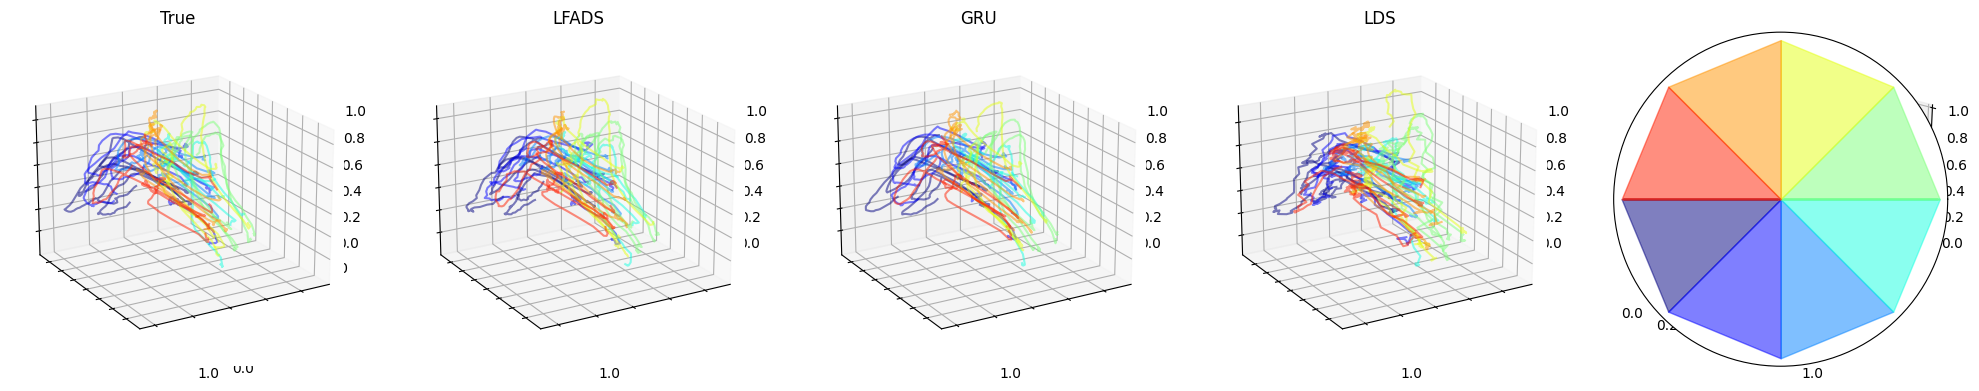

In [26]:

# Plot latents colored by reach angle bin
fig = plt.figure(figsize=(25, 10))
axes = fig.subplots(1, 5, sharex=True, sharey=True,  subplot_kw={'projection': '3d'})
ax1 = fig.add_subplot(1,5,1, projection='3d')
ax2 = fig.add_subplot(1,5,2, projection='3d')
ax3 = fig.add_subplot(1,5,3, projection='3d')
ax4 = fig.add_subplot(1,5,4, projection='3d')
ax5 = fig.add_subplot(1,5,5, projection='polar')


n_trials =5
plotted_trial_ang = []
for i in range(n_bins):
    color = plt.cm.jet(i / n_bins)
    for j in range(n_trials):
        trial = trial_list[i][j]
        plotted_trial_ang.append((reach_ang[trial], i))
        ax1.plot(lats_true_pca[trial][:,0], lats_true_pca[trial][:,1], lats_true_pca[trial][:,2], color=color, alpha=0.5)
        ax2.plot(lats_lfads_to_true[trial][:,0], lats_lfads_to_true[trial][:,1], lats_lfads_to_true[trial][:,2], color=color, alpha = 0.5)
        ax3.plot(lats_gru_to_true[trial][:,0], lats_gru_to_true[trial][:,1], lats_gru_to_true[trial][:,2], color=color, alpha = 0.5)
        ax4.plot(lats_lds_to_true[trial][:,0], lats_lds_to_true[trial][:,1], lats_lds_to_true[trial][:,2], color=color, alpha = 0.5)

ax1.set_title("True")
ax2.set_title("LFADS")
ax3.set_title("GRU")
ax4.set_title("LDS")

ax1.view_init(20, 60)
ax2.view_init(20, 60)
ax3.view_init(20, 60)
ax4.view_init(20, 60)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_zticklabels([])
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.set_zticklabels([])

# for ang, num in plotted_trial_ang:
#     ax5.plot([ang, ang], [0, 1], color=plt.cm.jet(num / n_bins))

for bin_num in range(n_bins):
    # Make surface plot of the angles on the unit circle
    ax5.fill_between([bins[bin_num], bins[bin_num+1]], [0, 0], [1, 1], color=plt.cm.jet(bin_num / n_bins), alpha=0.5)
ax5.set_rticks([])
ax5.set_xticks([])
plt.savefig("RT_radial.pdf")

In [27]:
print("3BFF")
metrics_3BFF = comparison_3BFF.compute_metrics(metric_list = ["rate_r2", "state_r2", "co-bps", "cycle_con"])

print("MT")
metrics_MT = comparison_MT.compute_metrics(metric_list = ["rate_r2", "state_r2", "co-bps", "cycle_con"])

print("RT")
metrics_RT = comparison_RT.compute_metrics(metric_list = ["rate_r2", "state_r2", "co-bps", "cycle_con"])

3BFF

Working on 1 of 4: GRU
Rate R2: 0.9677754640579224
State R2: 0.9604769349098206
CO-BPS: 0.13562071323394775
Cycle Consistency R2: 0.9180412888526917

Working on 2 of 4: LDS
Rate R2: 0.2440045028924942
State R2: 0.48734092712402344
CO-BPS: 0.035370707511901855
Cycle Consistency R2: 0.7225103378295898

Working on 3 of 4: LFADS
Rate R2: 0.9414657354354858
State R2: 0.8905355930328369
CO-BPS: 0.13072314858436584
Cycle Consistency R2: 0.7208324074745178

Working on 4 of 4: TT_3BFF
MT

Working on 1 of 3: LDS
Rate R2: 0.5521318316459656
State R2: 0.6759452223777771
CO-BPS: 0.09398244321346283
Cycle Consistency R2: 0.06149645149707794

Working on 2 of 3: LFADS
Rate R2: 0.7421475052833557
State R2: 0.8495888113975525
CO-BPS: 0.12083105742931366
Cycle Consistency R2: 0.4948154091835022

Working on 3 of 3: TT_MT
RT

Working on 1 of 4: GRU
Rate R2: 0.8070558905601501
State R2: 0.7836275100708008
CO-BPS: 0.0250660702586174
Cycle Consistency R2: 0.6070082783699036

Working on 2 of 4: LDS
Rate 